In [1]:
''' compute & plot taux, tauy, taux_correct, tauy_correct, raw & NI-bandpassed velocity, AND wind power input & integral of wind power input
    Saildrone wind data: 1-min average of 20Hz data.
    Saildrone current data: 5-min average of 1Hz data. 
    FOR drones that intercepted / close to HU LEE 2023: 
    (1) 1041 (~9/12 > 34 kt, N-PR, S of Lee) --> (later ~10/25 > 44 kt, N of Anguilla EEZ, around HU Tammy)
    (2) 1036 (~8/25 > 25 kt, N-PR, N of HU Franklin) --> (~9/13 > 50 kt, N-PR, N --> center --> S of Lee)
    (3) 1064 (~8/26 > 45 kt, N-PR, N & right side of HU Franklin) (~9/12 > 63 kt, N-PR, N & right side of Lee --> broke)
    (4) 1065 (~9/1 > 25 kt, N end of satellite line, NW side of post-tropical Idalia) (~9/13 > 45 kt, E of Domain E, N of Lee --> broke)
    (5) 1069 (~9/8 > 38 kt, Domain A, before it became HU Lee)
    ---
    This version computes hourly wind power from averaged wind and velocity. 
    This version includes the wind power to near-inertial motion
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import sys
import re
from numpy.linalg import norm
from scipy.interpolate import interp1d
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc, wind_adj2height_PL
from convert_dir import vector_dir_to_from
from mystats import bandpass
from values_to_colors import values_to_rgba

In [2]:
### Data info
### SD data info
year = '2023'
iSD = 2
platf_num = ['1036','1041','1069']
print('Now looking at SD-'+platf_num[iSD])
path_met_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_cur_SD = '/Users/chi/Documents/projects/sd-adcp-manipulate/check_adcp_redelivery/data_merge_adcp_redelivery/'
### merged nc file info
tlim_plot = [[datetime.datetime(int(year),9,7), datetime.datetime(int(year),9,19)],\
             [datetime.datetime(int(year),9,6), datetime.datetime(int(year),9,18)],\
                [datetime.datetime(int(year),9,3), datetime.datetime(int(year),9,15)]]
nday_plot = [(item[1]-item[0]).days for item in tlim_plot]
print(tlim_plot)
print(nday_plot,'days')
tticks = [tlim_plot[iSD][0]+datetime.timedelta(days=i) for i in range(nday_plot[iSD])]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

Now looking at SD-1069
[[datetime.datetime(2023, 9, 7, 0, 0), datetime.datetime(2023, 9, 19, 0, 0)], [datetime.datetime(2023, 9, 6, 0, 0), datetime.datetime(2023, 9, 18, 0, 0)], [datetime.datetime(2023, 9, 3, 0, 0), datetime.datetime(2023, 9, 15, 0, 0)]]
[12, 12, 12] days


SD met data time: [datetime.datetime(2023, 8, 4, 0, 0) datetime.datetime(2023, 8, 4, 0, 1)] ... 2023-11-05 23:59:00
Depths of SD cur: [6.0 8.000000000000002 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0
 30.0 32.0 34.0 36.0 38.0 40.0 42.0 44.0 46.0 48.0 50.0 52.0 54.0 56.0
 58.0 60.0 62.0 64.0 66.0 68.0 70.0 72.0 74.0 76.0 78.0 80.0 82.0 84.0
 86.0 88.0 90.0 92.0 94.0 96.0 98.0 100.0 102.0 104.0]
SD cur data time: [datetime.datetime(2023, 8, 4, 1, 0) datetime.datetime(2023, 8, 4, 1, 10)] ... 2023-11-05 23:40:00


<Figure size 432x288 with 0 Axes>

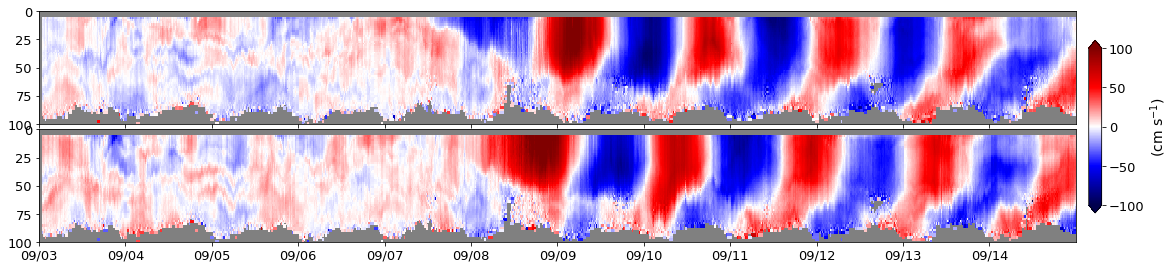

In [3]:
### load SD's airsea data
ds_met_SD = nc.Dataset(path_met_SD+'airsea-raw-merge-'+year+'-SD'+platf_num[iSD]+'.nc')
time = ds_met_SD.variables['time'][:]
dtime_met_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
lon_met_SD = ds_met_SD.variables['longitude'][:]
lat_met_SD = ds_met_SD.variables['latitude'][:]
uwnd_SD = ds_met_SD.variables['UWND_MEAN'][:]
vwnd_SD = ds_met_SD.variables['VWND_MEAN'][:]
print('SD met data time:',dtime_met_SD[0:2],'...',dtime_met_SD[-1])

### LOAD SD CURRENT VELOCITY DATA ###
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num[iSD]+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uCur_SD = ds_cur_SD.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_cur_SD.variables['vel_north'][:]*100
depths_cur_SD = ds_cur_SD.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
depths_cur_SD[0] = 6
# data_flag = ds_cur_SD.variables['data_flag'][:]
print('Depths of SD cur:',depths_cur_SD)
print('SD cur data time:',dtime_cur_SD[0:2],'...',dtime_cur_SD[-1])
### apply nan to flagged values
# uCur_SD[data_flag > 0] = np.nan
# vCur_SD[data_flag > 0] = np.nan
### plot
it = np.where( (dtime_cur_SD>= tlim_plot[iSD][0]) & (dtime_cur_SD< tlim_plot[iSD][1]) )[0]
plt.clf()
fig = plt.figure(figsize=(18,4))
plt.rcParams.update({'font.size': 13})
plt.subplot(2,1,1)
cs = plt.pcolor(dtime_cur_SD[it], depths_cur_SD, uCur_SD[it,:].transpose(),cmap='seismic',vmin=-100,vmax=100)
plt.subplot(2,1,2)
plt.pcolor(dtime_cur_SD[it], depths_cur_SD, vCur_SD[it,:].transpose(),cmap='seismic',vmin=-100,vmax=100)
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.ylim([0,100])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot[iSD])
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label)
    plt.gca().set_facecolor('gray')
    if i< 1:
        plt.gca().set_xticklabels([])
    
###
axf = fig.add_axes([0.91,0.2,0.01,0.6])
axf = plt.colorbar(cs,orientation='vertical',cax=axf,extend='both')
axf.set_label('(cm s$^{-1}$)',fontsize=14)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
###
# plt.savefig('time-depth-uv_'+year+'-SD'+platf_num[iSD]+'_'+\
#             tlim_plot[iSD][0].strftime('%Y%m%d-')+tlim_plot[iSD][1].strftime('%Y%m%d')+\
#             '.png', dpi=600,bbox_inches='tight')

In [4]:
### linearly interpolate temporal grid
dsec_grid = datetime.timedelta(minutes=10).total_seconds()
nt_grid = int( (tlim_plot[iSD][1]-tlim_plot[iSD][0]).total_seconds()/dsec_grid )
dtime_grid = np.array([tlim_plot[iSD][0]+datetime.timedelta(seconds=i*dsec_grid) for i in range(nt_grid)])
print('current velocity temporal grid:',dtime_grid[0:2],dtime_grid[-1])
timestamp_grid = np.array([item.timestamp() for item in dtime_grid])
timestamp_met_SD = np.array([item.timestamp() for item in dtime_met_SD])
timestamp_cur_SD = np.array([item.timestamp() for item in dtime_cur_SD])
''' longitude / latitude '''
itOK = ~np.isnan( lon_met_SD )
lon_SD_grid = np.interp( timestamp_grid, timestamp_met_SD[itOK], lon_met_SD[itOK])
lat_SD_grid = np.interp( timestamp_grid, timestamp_met_SD[itOK], lat_met_SD[itOK])
''' wind '''
itOK = ~np.isnan( uwnd_SD )
uwnd_SD_grid = np.interp(timestamp_grid, timestamp_met_SD[itOK], uwnd_SD[itOK])
vwnd_SD_grid = np.interp(timestamp_grid, timestamp_met_SD[itOK], vwnd_SD[itOK])
''' current velocity '''
ucur_SD_grid = np.nan*np.ones( (len(dtime_grid),len(depths_cur_SD)) )
vcur_SD_grid = ucur_SD_grid.copy()
for z in range( len(depths_cur_SD) ):
    itOK = ~np.isnan( uCur_SD[:,z] )
    if np.sum(len(itOK)) > 0:
        # print(depths_cur_SD[z],'m pass')
        ucur_SD_grid[:,z] = np.interp( timestamp_grid, timestamp_cur_SD[itOK], uCur_SD[itOK,z] )
        vcur_SD_grid[:,z] = np.interp( timestamp_grid, timestamp_cur_SD[itOK], vCur_SD[itOK,z] )

current velocity temporal grid: [datetime.datetime(2023, 9, 3, 0, 0) datetime.datetime(2023, 9, 3, 0, 10)] 2023-09-14 23:50:00


' save figure '

<Figure size 432x288 with 0 Axes>

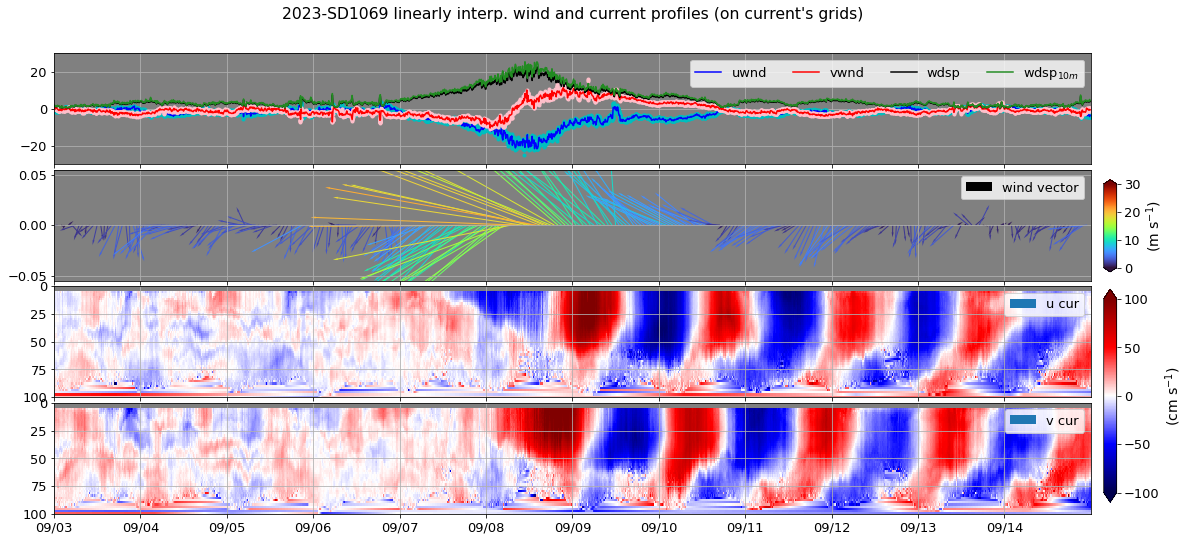

In [5]:
''' (interpolated temporal grids) plot time series of wind & time-depth of current velocity '''
### plot
nrow = 4
it = np.where( (dtime_grid>= tlim_plot[iSD][0]) & (dtime_grid< tlim_plot[iSD][1]) )[0]
''' settings for quiver wind '''
nskip = 6
width = 0.001
scale = 100
headwidth = 2
speed = np.sqrt( np.square(uwnd_SD_grid[::nskip]) + np.square(vwnd_SD_grid[::nskip]) )
_,norm_speed,cmap_speed = values_to_rgba(speed,'turbo',vmin=0,vmax=30)
''' settings for current velocity '''
curspdlim = [-100, 100]
plt.clf()
fig = plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 13})
''' u & v wind, wdsp '''
plt.subplot(nrow,1,1)
plt.plot(dtime_met_SD, uwnd_SD,'c.')
plt.plot(dtime_grid[it], uwnd_SD_grid[it],'b-',label='uwnd')
plt.plot(dtime_met_SD, vwnd_SD,'.',color='pink')
plt.plot(dtime_grid[it], vwnd_SD_grid[it],'r-',label='vwnd')
wdsp = np.sqrt( np.square(uwnd_SD_grid[it]) + np.square(vwnd_SD_grid[it]) )
wdsp_10m = wind_adj2height_PL( wdsp, 3.5, 10 )
plt.plot(dtime_grid[it], wdsp, 'k-',label='wdsp')
plt.plot(dtime_grid[it], wdsp_10m, '-',color='forestgreen',label='wdsp$_{10m}$')
''' quiver wind plot '''
plt.subplot(nrow,1,2)
cq = plt.quiver(dtime_grid[::nskip],np.zeros(dtime_grid[::nskip].shape), \
           uwnd_SD_grid[::nskip],vwnd_SD_grid[::nskip],speed, \
            width=width, scale=scale,headwidth=headwidth,cmap=cmap_speed,norm=norm_speed,label='wind vector')
''' u & v current velocity '''
plt.subplot(nrow,1,3)
cs = plt.pcolor(dtime_grid[it], depths_cur_SD, ucur_SD_grid[it,:].transpose(),\
                cmap='seismic',vmin=curspdlim[0],vmax=curspdlim[1],label='u cur')
plt.subplot(nrow,1,4)
plt.pcolor(dtime_grid[it], depths_cur_SD, vcur_SD_grid[it,:].transpose(),\
           cmap='seismic',vmin=curspdlim[0],vmax=curspdlim[1],label='v cur')
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    if i > 1:
        plt.ylim([0,100])
        plt.gca().invert_yaxis()
    plt.xlim(tlim_plot[iSD])
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label)
    plt.gca().set_facecolor('gray')
    plt.legend(ncol=4,loc='best')
    plt.grid()
    if i == 0:
        plt.ylim([-30,30])
    if i< nrow-1:
        plt.gca().set_xticklabels([])
''' colorbar for wind speed '''
axq = fig.add_axes([0.91,0.52,0.01,0.16])
axq = plt.colorbar(cq,orientation='vertical',cax=axq,extend='both')
axq.set_label('(m s$^{-1}$)',fontsize=14)
''' colorbar for u & v current velocity '''
axf = fig.add_axes([0.91,0.12,0.01,0.37])
axf = plt.colorbar(cs,orientation='vertical',cax=axf,extend='both')
axf.set_label('(cm s$^{-1}$)',fontsize=14)
###
plt.suptitle(year+'-SD'+platf_num[iSD]+" linearly interp. wind and current profiles (on current's grids)")
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
''' save figure '''
# plt.savefig('time-depth-interp-uv(wnd_n_cur)_'+year+'-SD'+platf_num[iSD]+'_'+\
#             tlim_plot[iSD][0].strftime('%Y%m%d-')+tlim_plot[iSD][1].strftime('%Y%m%d')+\
#             '.png', dpi=600,bbox_inches='tight')

In [6]:
''' compute the wind stress '''
iz = np.argmin( np.abs(depths_cur_SD-6) )
roh = 1.2
''' corrected wind stress by current velocity '''
taux_c_SD_grid, tauy_c_SD_grid = ra_windstr_nc(uwnd_SD_grid-0.01*ucur_SD_grid[:,iz], vwnd_SD_grid-0.01*vcur_SD_grid[:,iz],roh)
u10 = wind_adj2height_PL(uwnd_SD_grid,3.5,10)
v10 = wind_adj2height_PL(vwnd_SD_grid,3.5,10)
taux10m_c_SD_grid, tauy10m_c_SD_grid = ra_windstr_nc(u10-0.01*ucur_SD_grid[:,iz], v10-0.01*vcur_SD_grid[:,iz],roh)

Text(0.5, 0.98, "2023-SD1069 linearly interp. wind(3.5m) and shallowest current (on current's grids)")

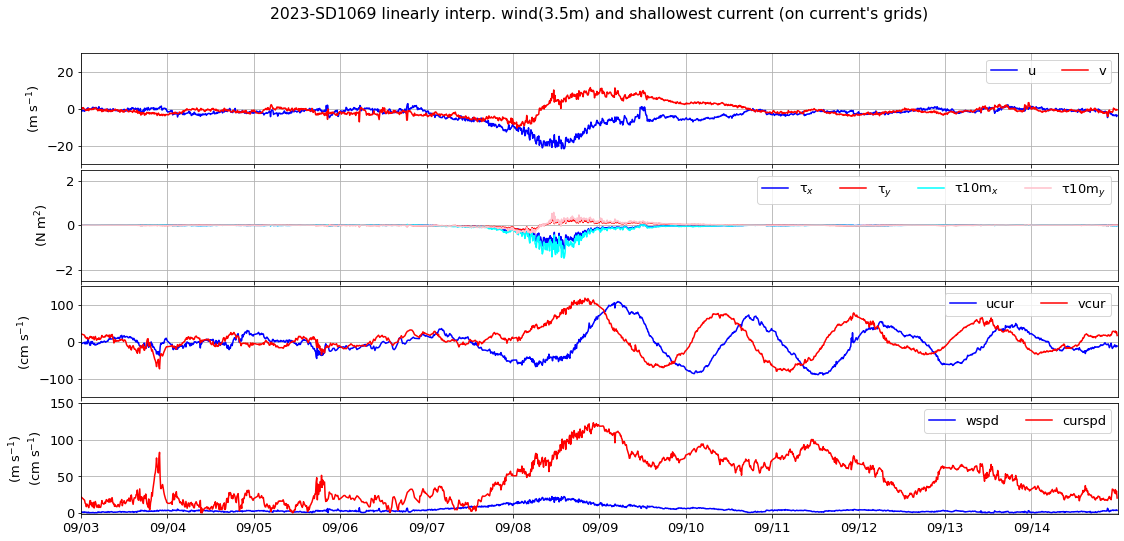

In [7]:
### plot the linearly interpolated wind and current (on current's grids)
wspd_SD_grid = np.sqrt( np.square(uwnd_SD_grid) + np.square(vwnd_SD_grid) )
curspd_SD_grid = np.sqrt( np.square(ucur_SD_grid) + np.square(vcur_SD_grid) )
###
var_str = [['uwnd','vwnd'],['taux_c','tauy_c','taux10m_c','tauy10m_c'],['ucur','vcur'],['wspd','curspd']]
var_str_label = [['u','v'],['\u03C4'+'$_x$','\u03C4'+'$_y$','\u03C4'+'10m$_x$','\u03C4'+'10m$_y$'],['ucur','vcur'],['wspd','curspd']]
var_unit = ['(m s$^{-1}$)','(N m$^2$)','(cm s$^{-1}$)',['(m s$^{-1}$)','(cm s$^{-1}$)']]
col_in1 = ['blue','red','cyan','pink']
var_lim = [[-30,30],[-2.5,2.5],[-150,150],[-1,150]]
### 
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 8)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    for v in range( len(var_str[i]) ):
        exec_str1 = 'var1 = '+var_str[i][v]+'_SD_grid'
        if ('cur' in var_str[i][v]):# & ('spd' not in var_str[i][v]):
            exec_str1 = exec_str1+'[:,iz]'
        exec(exec_str1)
        plt.plot(dtime_grid, var1, color=col_in1[v], label=var_str_label[i][v])
    plt.legend(ncol=6,loc='best')
    if isinstance(var_unit[i],str):
        plt.ylabel(var_unit[i])
    else:
        plt.ylabel('\n'.join(var_unit[i]))
    ### figure settings
    plt.xticks(tticks,rotation=0)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot[iSD])
    plt.grid()
    plt.ylim(var_lim[i])
    if i < nrow-1:
        plt.gca().set_xticklabels([])
    
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle(year+'-SD'+platf_num[iSD]+" linearly interp. wind(3.5m) and shallowest current (on current's grids)")
### save to figure
# plt.savefig('timeseries_wind_tau_c_cur_spd_'+year+'-SD'+platf_num[iSD]+'({:.1f}m)'.format(depths_cur_SD[iz])+'_'+\
#             tlim_plot[iSD][0].strftime('%Y%m%d-')+tlim_plot[iSD][1].strftime('%m%d')+'_{:.1f}-sec-grid.png'.format(dsec_grid),\
#                 dpi=400,bbox_inches='tight')

In [8]:
''' band pass current velocity to NI band '''
n_f = np.array([0.8,1.2])
itOK = np.where( (dtime_met_SD>= tlim_plot[iSD][0]) & (dtime_met_SD< tlim_plot[iSD][1]) )[0]
lat_mn = np.nanmean(lat_met_SD[itOK])
f_mn = 2*(2*np.pi/86400)*np.sin(lat_mn/180*np.pi) # 1/s
f_bp = f_mn*n_f
bp_sec = 2*np.pi/f_bp

''' band pass '''
ucur_SD_grid_bp = np.nan*np.ones( ucur_SD_grid.shape )
vcur_SD_grid_bp = ucur_SD_grid_bp.copy()
for z in range( ucur_SD_grid_bp.shape[1] ):
    ucur_SD_grid_bp[:,z], _,_,_,_  = bandpass(ucur_SD_grid[:,z],dsec_grid,bp_sec[0],bp_sec[1],2)
    vcur_SD_grid_bp[:,z], _,_,_,_  = bandpass(vcur_SD_grid[:,z],dsec_grid,bp_sec[0],bp_sec[1],2)

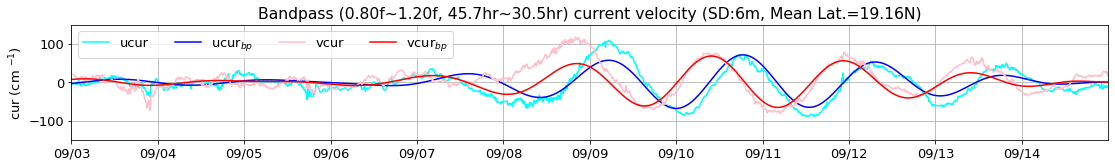

In [9]:
col_in1 = [['cyan','blue'],['pink','red'],['teal','green']]
### plot current
nrow = 1
plt.clf()
plt.gcf().set_size_inches(18, 2)
plt.rcParams.update({'font.size': 13})
### u
plt.subplot(nrow,1,1)
plt.plot(dtime_grid, ucur_SD_grid[:,iz],label='ucur',color=col_in1[0][0])
plt.plot(dtime_grid, ucur_SD_grid_bp[:,iz],label='ucur$_{bp}$',color=col_in1[0][1])
# plt.ylabel('ucur (cm $^{-1}$)')
### v
# plt.subplot(nrow,1,2)
plt.plot(dtime_grid, vcur_SD_grid[:,iz],label='vcur',color=col_in1[1][0])
plt.plot(dtime_grid, vcur_SD_grid_bp[:,iz],label='vcur$_{bp}$',color=col_in1[1][1])
plt.ylabel('cur (cm $^{-1}$)')
plt.legend(ncol=6,loc='best')
###
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=0)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot[iSD])
    plt.grid()
    plt.ylim([-150,150])
    if i< nrow-1:
        plt.gca().set_xticklabels([])
    
plt.title('Bandpass ({:.2f}f~{:.2f}f, {:.1f}hr~{:.1f}hr) current velocity (SD:{:.0f}m, Mean Lat.={:.2f}N)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,depths_cur_SD[iz],lat_mn))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
### save to figure
# plt.savefig('timeseries_cur-bp({:.2f}f~{:.2f}f)_'.format(n_f[0],n_f[1])+year+'-SD'+platf_num[iSD]+'({:.1f}m)'.format(depths_cur_SD[iz])+'_'+\
#             tlim_plot[iSD][0].strftime('%Y%m%d-')+tlim_plot[iSD][1].strftime('%m%d')+'_{:.1f}-sec-grid.png'.format(dsec_grid),\
#                 dpi=400,bbox_inches='tight')

In [10]:
### compute wind power (N m^-2)*(m s^-1)= N m^-1 s^-1 = J m^-2 s^-1 = W m^-2
tau_dot_sfcvel_SD = np.multiply(taux_c_SD_grid,(0.01*ucur_SD_grid_bp[:,iz])) +\
    np.multiply(tauy_c_SD_grid,(0.01*vcur_SD_grid_bp[:,iz]))
tau10m_dot_sfcvel_SD = np.multiply(taux10m_c_SD_grid,(0.01*ucur_SD_grid_bp[:,iz])) +\
    np.multiply(tauy10m_c_SD_grid,(0.01*vcur_SD_grid_bp[:,iz]))
### compute energy input (W m^-2)*(s) = J m^-2
energy_input_SD = np.nan*np.ones( (len(dtime_grid),) )
energy_input_adj10m_SD = energy_input_SD.copy()
for i in range( len(dtime_grid) ):
    ###
    nan_mask = ~np.isnan(tau_dot_sfcvel_SD)
    y_clean = tau_dot_sfcvel_SD[nan_mask]
    x_clean = timestamp_grid[nan_mask]
    energy_input_SD[i] = np.trapz(y_clean[:i+1],x_clean[:i+1])  
    ''' result using wind adjusted to 10m '''
    nan_mask = ~np.isnan(tau10m_dot_sfcvel_SD)
    y_clean = tau10m_dot_sfcvel_SD[nan_mask]
    x_clean = timestamp_grid[nan_mask]
    energy_input_adj10m_SD[i] = np.trapz(y_clean[:i+1],x_clean[:i+1])  

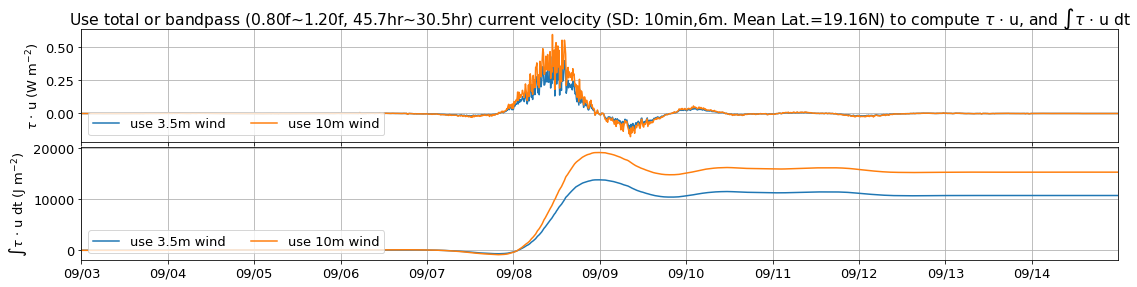

In [11]:
### plot wind power (tau dot NI current velocity in W m^-2) and energy input (integrate wind power over time in J m^-2)
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 4)
plt.rcParams.update({'font.size': 13})
### wind power
plt.subplot(nrow,1,1)
plt.plot( dtime_grid, tau_dot_sfcvel_SD, label='use 3.5m wind')
plt.plot( dtime_grid, tau10m_dot_sfcvel_SD, label='use 10m wind')
plt.ylabel('$\u03C4$ $\cdot$ u (W m$^{-2}$)')
### energy input
plt.subplot(nrow,1,2)
plt.plot( dtime_grid, energy_input_SD, label='use 3.5m wind')
plt.plot( dtime_grid, energy_input_adj10m_SD, label='use 10m wind')
plt.ylabel('$\int$$\u03C4$ $\cdot$ u dt (J m$^{-2}$)')
### figure setting
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=0)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot[iSD])
    plt.grid()
    plt.legend(ncol=6, loc='lower left')
    if i< nrow-1:
        plt.gca().set_xticklabels([])
    # if i == 1:
    #     plt.ylim([0,1500])

plt.suptitle('Use total or bandpass ({:.2f}f~{:.2f}f, {:.1f}hr~{:.1f}hr) current velocity (SD: {:.0f}min,{:.0f}m. Mean Lat.={:.2f}N)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600, dsec_grid/60,depths_cur_SD[iz],lat_mn)+\
                ' to compute $\u03C4$ $\cdot$ u, and $\int$$\u03C4$ $\cdot$ u dt')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
### save figure
# plt.savefig('timeseries_wind-power_energy-input_total-vs-bp({:.2f}f~{:.2f}f)_'.format(n_f[0],n_f[1])+\
#             year+'-SD'+platf_num[iSD]+'({:.1f}m)'.format(depths_cur_SD[iz])+'_'+\
#             tlim_plot[iSD][0].strftime('%Y%m%d-')+tlim_plot[iSD][1].strftime('%m%d')+'_{:.1f}-sec-grid.png'.format(dsec_grid),\
#                 dpi=400,bbox_inches='tight')

In [12]:
print('=== results by bandpass '+year+'-SD'+platf_num[iSD]+' {:.0f}m current velocity at {:.2f}f~{:.2f}f band: ==='.format(depths_cur_SD[iz],n_f[0],n_f[1]))
if platf_num[iSD] == '1069':
    tlim_check = [datetime.datetime(int(year),9,11),datetime.datetime(int(year),9,12)] # 1069
else:
    tlim_check = [datetime.datetime(int(year),9,16),datetime.datetime(int(year),9,17)] # 1036 & 1041
it = np.where( (dtime_grid>= tlim_check[0]) & (dtime_grid<= tlim_check[1]) )[0]
''' '''
mn = np.mean( energy_input_SD[it] )
mn_10m = np.mean( energy_input_adj10m_SD[it] )
print('SD mean energy input btw',tlim_check,'= {:.2f}, use 10m wind result: {:.2f} (J/m^2)'.format(mn,mn_10m))

=== results by bandpass 2023-SD1069 6m current velocity at 0.80f~1.20f band: ===
SD mean energy input btw [datetime.datetime(2023, 9, 11, 0, 0), datetime.datetime(2023, 9, 12, 0, 0)] = 11339.86, use 10m wind result: 16030.78 (J/m^2)


In [13]:
''' write data to file: timestamp_grid, taux, tauy, u6m, v6m, u6m(bp), v6m(bp), wind power, energy input '''
print(timestamp_grid.shape,taux_c_SD_grid.shape, ucur_SD_grid.shape, ucur_SD_grid_bp.shape)
print(tau_dot_sfcvel_SD.shape, energy_input_SD.shape)
vars_str = ['timestamp_grid','lon_SD_grid','lat_SD_grid','taux_c_SD_grid','tauy_c_SD_grid','taux10m_c_SD_grid','tauy10m_c_SD_grid',\
            'ucur_SD_grid[:,iz]','vcur_SD_grid[:,iz]','ucur_SD_grid_bp[:,iz]','vcur_SD_grid_bp[:,iz]',\
                'tau_dot_sfcvel_SD','energy_input_SD','tau10m_dot_sfcvel_SD','energy_input_adj10m_SD']
for i, var_str in enumerate( vars_str ):
    if i == 0:
        out_array = eval(var_str)
    else:
        out_array = np.column_stack( (out_array, eval(var_str)) )
print(out_array.shape)
''' save to file '''
fn_out = 'timeseries_wnd_cur_bp({:.2f}f-{:.2f}f)_wp_energy_'.format(n_f[0],n_f[1])+year+'-SD'+platf_num[iSD]+'_'+\
    tlim_plot[iSD][0].strftime('%Y%m%d-')+tlim_plot[iSD][1].strftime('%m%d')+'_{:.1f}-sec-grid'.format(dsec_grid)+'.txt'
np.savetxt(fn_out, out_array, delimiter=' ',header= ', '.join(vars_str))

(1728,) (1728,) (1728, 50) (1728, 50)
(1728,) (1728,)
(1728, 15)
